In [2]:
from itertools import product
from operator import itemgetter
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    balanced_accuracy_score, 
    classification_report,
    confusion_matrix, 
    f1_score,
    precision_recall_fscore_support)

from embedded_tabular_data import prepare_tabular_dataset

# RF est invariant à la permutation des features : Il ne multiplie jamais ou ne regroupe jamais plusieurs 
# features voisines pour détecter une relation locale (comme le ferait un CNN ou une fenêtre glissante paramétrique)

In [3]:
DSSP_8_CLASSES = 'HGEBITSL'
DSSP_3_MAP = {
    'H': 'H',  # Alpha Helix
    'G': 'H',  # 3-10 Helix
    'I': 'H',  # Pi Helix
    'E': 'E',  # Beta Strand
    'B': 'E',  # Beta Bridge
    'T': 'C',  # Turn
    'S': 'C',  # Bend
    'L': 'C',  # Loop / Coil
    '-': 'C',  # Missing → Coil
}
def encode_secondary_structure(ss_seq):
    """Mappe la structure secondaire DSSP (8 classes) vers 3 classes H/E/C"""
    return [DSSP_3_MAP.get(s, 'C') for s in ss_seq]



In [5]:
X_train,y_train = prepare_tabular_dataset("../../data/matches_subset_dssp.json",11)
y_train = encode_secondary_structure(y_train)
y_train = np.array(y_train)


X_val,y_val = prepare_tabular_dataset("../../data/validation_matches_subset_dssp.json",10)
y_val = encode_secondary_structure(y_val)
y_val = np.array(y_val)

In [37]:
X_train.shape

(2270581, 121)

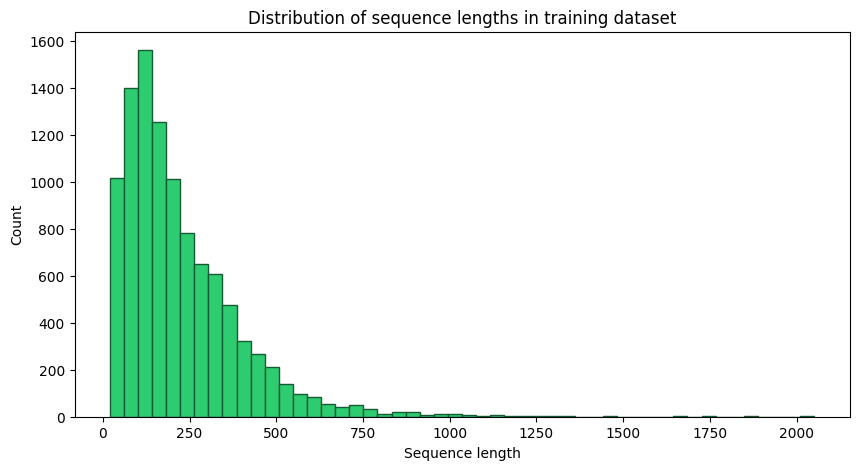

In [ ]:
import json
import matplotlib.pyplot as plt

json_path = "../../data/matches_subset_dssp.json"

# Charger les données
with open(json_path, "r") as f:
    data = json.load(f)

# Extraire les longueurs
lengths = [len(entry["primary_sequence"]) for entry in data]



In [50]:
len(data)

10174

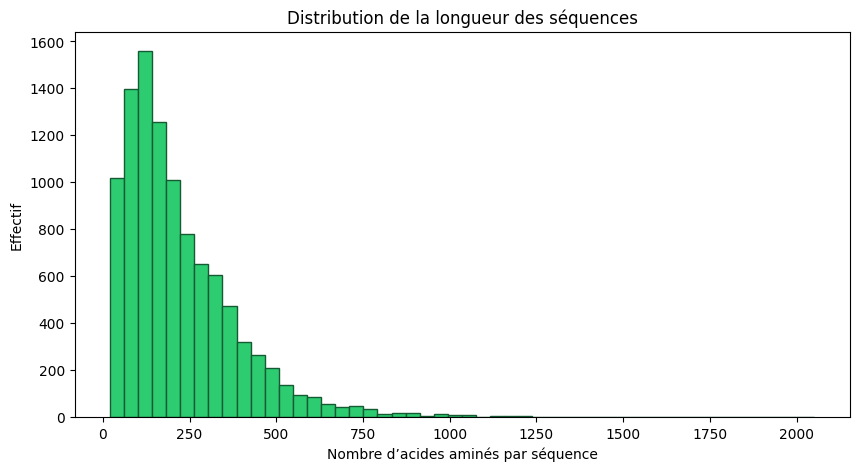

In [43]:
# Tracer en vert
plt.figure(figsize=(10,5))
plt.hist(lengths, bins=50, color="#2ecc71", edgecolor="#145a32")
plt.xlabel("Nombre d’acides aminés par séquence")
plt.ylabel("Effectif")
plt.title("Distribution de la longueur des séquences")
plt.show()

In [46]:
np.mean(lengths)

np.float64(223.1748574798506)

In [ ]:


# Taille de l'échantillon pour tuning rapide des hypers paramètres 
sample_size = 200000
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train, train_size=sample_size, stratify=y_train, random_state=42
)


In [35]:
# Valeurs uniques et leurs comptes
valeurs_uniques, counts = np.unique(y_train, return_counts=True)
for valeur, count in zip(valeurs_uniques, counts):
    print(valeur, count)

C 1011153
E 472863
H 786565


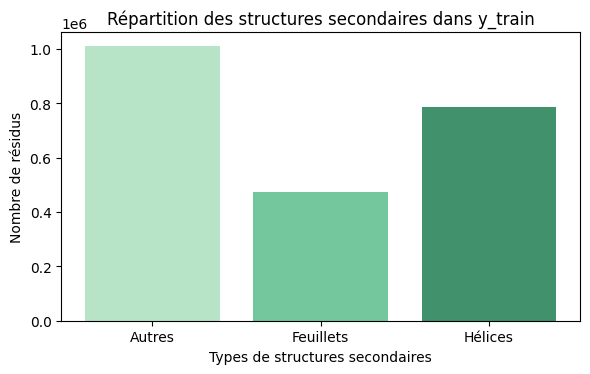

In [40]:
import matplotlib.pyplot as plt

labels = ["Autres", "Feuillets", "Hélices"]
counts = [1011153, 472863, 786565]

plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=["#b7e4c7", "#74c69d", "#40916c"])
plt.xlabel("Types de structures secondaires")
plt.ylabel("Nombre de résidus")
plt.title("Répartition des structures secondaires dans y_train")
plt.tight_layout()
plt.show()

In [ ]:

def train_rf_simple(X_train, y_train,
             n_estimators, max_depth,
             min_samples_leaf,max_features='sqrt', 
             random_state=42,  verbose=1):
    """
    Entraîne un Random Forest sur X_train/y_train, évalue sur X_val/y_val.
    Calcule Accuracy, Q3 et retourne le modèle ainsi que les scores.
    Optionnellement sauvegarde le modèle.
    """
    # Création du modèle
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1,
        random_state=random_state,
        verbose=verbose
    )
    
    print("Fitting Random Forest...")
    rf.fit(X_train, y_train)
    return rf

In [92]:

# Grille d'hyperparamètres à evaluer ;) 
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 20, 30],
    'max_features': ['sqrt', 'log2', 0.5],
    'min_samples_leaf': [1, 5, 10]
}

# stockage  des résultats
results = []

# Boucle sur toutes les combinaisons d'hypers paramètres 
for n_est, depth, mf, min_leaf in product(
        param_grid['n_estimators'],
        param_grid['max_depth'],
        param_grid['max_features'],
        param_grid['min_samples_leaf']):
    
    print(f"\nTesting params: n_estim={n_est}, max_depth={depth}, max_features={mf}, min_samples_leaf={min_leaf}")
    
    # Entraînement
    rf = train_rf_simple(
        X_sample, y_sample,
        n_estimators= n_est,
        min_samples_leaf = min_leaf,
        max_depth= depth,
        max_features= mf
    )
    
    # Prédiction sur le set de validation
    y_val_pred = rf.predict(X_val)
    
    # Calcul des métriques
    acc = accuracy_score(y_val, y_val_pred)
    bal_acc = balanced_accuracy_score(y_val, y_val_pred)
    macro_f1 = f1_score(y_val, y_val_pred, average='macro')
    classes = ['H', 'E', 'C']
    mask = np.isin(y_val, classes)
    q3 = np.mean(y_val[mask] == y_val_pred[mask])
    
    print("Accuracy:", acc)
    print("Balanced accuracy:", bal_acc)
    print("Macro F1:", macro_f1)
    
    # Stockage des résultats
    results.append({
        'params': {
            'n_estimators': n_est,
            'max_depth': depth,
            'max_features': mf,
            'min_samples_leaf': min_leaf
        },
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'macro_f1': macro_f1,
        'Q3': q3
    })

# Affichage résumé
print("\nRésultats complets :")
for r in results:
    print(r)


Testing params: n_estim=50, max_depth=None, max_features=sqrt, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


Accuracy: 0.6324687110867225
Balanced accuracy: 0.5862223053047235
Macro F1: 0.5934657573017833

Testing params: n_estim=50, max_depth=None, max_features=sqrt, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


Accuracy: 0.6350646883771977
Balanced accuracy: 0.5876266731821742
Macro F1: 0.5948016150479055

Testing params: n_estim=50, max_depth=None, max_features=sqrt, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6373651885777
Balanced accuracy: 0.5894551015712725
Macro F1: 0.5971063985678476

Testing params: n_estim=50, max_depth=None, max_features=log2, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


Accuracy: 0.6317722293746438
Balanced accuracy: 0.5828279104007097
Macro F1: 0.5904839698389613

Testing params: n_estim=50, max_depth=None, max_features=log2, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


Accuracy: 0.6364576518013549
Balanced accuracy: 0.5849024567698774
Macro F1: 0.5923757183341015

Testing params: n_estim=50, max_depth=None, max_features=log2, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6364365462949283
Balanced accuracy: 0.5839650738699648
Macro F1: 0.591653444159441

Testing params: n_estim=50, max_depth=None, max_features=0.5, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


Accuracy: 0.632785293683122
Balanced accuracy: 0.5869372988941977
Macro F1: 0.5937419843186332

Testing params: n_estim=50, max_depth=None, max_features=0.5, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6343471011586923
Balanced accuracy: 0.5889425377044147
Macro F1: 0.5959629437311653

Testing params: n_estim=50, max_depth=None, max_features=0.5, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


Accuracy: 0.6342837846394124
Balanced accuracy: 0.5887143470548143
Macro F1: 0.5958511187992978

Testing params: n_estim=50, max_depth=20, max_features=sqrt, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


Accuracy: 0.6335661974209071
Balanced accuracy: 0.586891036715416
Macro F1: 0.5938862257259188

Testing params: n_estim=50, max_depth=20, max_features=sqrt, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


Accuracy: 0.6361410692049556
Balanced accuracy: 0.5883673779514367
Macro F1: 0.5958810019135573

Testing params: n_estim=50, max_depth=20, max_features=sqrt, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6364576518013549
Balanced accuracy: 0.5875344177121499
Macro F1: 0.5950810500484753

Testing params: n_estim=50, max_depth=20, max_features=log2, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


Accuracy: 0.6339460965365864
Balanced accuracy: 0.5833390835221175
Macro F1: 0.5905979789519368

Testing params: n_estim=50, max_depth=20, max_features=log2, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.636056647179249
Balanced accuracy: 0.5845025951199813
Macro F1: 0.5919723427248912

Testing params: n_estim=50, max_depth=20, max_features=log2, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6356767480635698
Balanced accuracy: 0.5834784925123006
Macro F1: 0.5911459637318394

Testing params: n_estim=50, max_depth=20, max_features=0.5, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


Accuracy: 0.6330174542538148
Balanced accuracy: 0.5876470360533443
Macro F1: 0.5946307778365261

Testing params: n_estim=50, max_depth=20, max_features=0.5, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6349802663514911
Balanced accuracy: 0.5891436361660944
Macro F1: 0.5961107635826605

Testing params: n_estim=50, max_depth=20, max_features=0.5, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6372596610455667
Balanced accuracy: 0.5907222856644144
Macro F1: 0.5979044156632201

Testing params: n_estim=50, max_depth=30, max_features=sqrt, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


Accuracy: 0.6280365547371309
Balanced accuracy: 0.5813972182405269
Macro F1: 0.5884232603429354

Testing params: n_estim=50, max_depth=30, max_features=sqrt, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


Accuracy: 0.6353179544543172
Balanced accuracy: 0.5881794750211052
Macro F1: 0.595438395336022

Testing params: n_estim=50, max_depth=30, max_features=sqrt, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6369430784491674
Balanced accuracy: 0.5889081237279635
Macro F1: 0.5965411540706435

Testing params: n_estim=50, max_depth=30, max_features=log2, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6321521284903231
Balanced accuracy: 0.582529281495844
Macro F1: 0.5898380079703208

Testing params: n_estim=50, max_depth=30, max_features=log2, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


Accuracy: 0.6351280048964775
Balanced accuracy: 0.5840665020382699
Macro F1: 0.5915100552379277

Testing params: n_estim=50, max_depth=30, max_features=log2, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6364998628142082
Balanced accuracy: 0.5836133947880467
Macro F1: 0.5910107466655862

Testing params: n_estim=50, max_depth=30, max_features=0.5, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


Accuracy: 0.6307169540533125
Balanced accuracy: 0.5853494952404311
Macro F1: 0.5923351729434667

Testing params: n_estim=50, max_depth=30, max_features=0.5, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


Accuracy: 0.6344948397036787
Balanced accuracy: 0.5890659933894185
Macro F1: 0.5960813880503478

Testing params: n_estim=50, max_depth=30, max_features=0.5, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6342837846394124
Balanced accuracy: 0.5887143470548143
Macro F1: 0.5958511187992978

Testing params: n_estim=100, max_depth=None, max_features=sqrt, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6373651885777
Balanced accuracy: 0.5911465602380916
Macro F1: 0.5988276735922725

Testing params: n_estim=100, max_depth=None, max_features=sqrt, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6402144319452945
Balanced accuracy: 0.5922950575310189
Macro F1: 0.599997234641592

Testing params: n_estim=100, max_depth=None, max_features=sqrt, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


Accuracy: 0.6385259914311644
Balanced accuracy: 0.5898252486829473
Macro F1: 0.597322386395053

Testing params: n_estim=100, max_depth=None, max_features=log2, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6395812667524957
Balanced accuracy: 0.5902039463597141
Macro F1: 0.5983156225092453

Testing params: n_estim=100, max_depth=None, max_features=log2, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6398134273231886
Balanced accuracy: 0.5879967485643784
Macro F1: 0.5957201885282634

Testing params: n_estim=100, max_depth=None, max_features=log2, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6387370464954306
Balanced accuracy: 0.586132968130387
Macro F1: 0.5938959664875593

Testing params: n_estim=100, max_depth=None, max_features=0.5, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   54.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6367742343977544
Balanced accuracy: 0.5909182981166358
Macro F1: 0.5980621392883977

Testing params: n_estim=100, max_depth=None, max_features=0.5, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6378295097190857
Balanced accuracy: 0.5923724782760287
Macro F1: 0.5996889190606495

Testing params: n_estim=100, max_depth=None, max_features=0.5, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy: 0.6363099132563685
Balanced accuracy: 0.5901240831019412
Macro F1: 0.5973668199501919

Testing params: n_estim=100, max_depth=20, max_features=sqrt, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6379772482640721
Balanced accuracy: 0.5912988589152234
Macro F1: 0.5988546840703978

Testing params: n_estim=100, max_depth=20, max_features=sqrt, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6385048859247378
Balanced accuracy: 0.5902127602845741
Macro F1: 0.5977374839687105

Testing params: n_estim=100, max_depth=20, max_features=sqrt, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy: 0.638378252886178
Balanced accuracy: 0.5893077411391902
Macro F1: 0.5967940517494612

Testing params: n_estim=100, max_depth=20, max_features=log2, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6384837804183111
Balanced accuracy: 0.5880508884631794
Macro F1: 0.5958449694261563

Testing params: n_estim=100, max_depth=20, max_features=log2, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6392857896625229
Balanced accuracy: 0.5871934121415511
Macro F1: 0.594860619287186

Testing params: n_estim=100, max_depth=20, max_features=log2, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy: 0.6379983537704987
Balanced accuracy: 0.5852077957415872
Macro F1: 0.592768102117944

Testing params: n_estim=100, max_depth=20, max_features=0.5, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6380616702897786
Balanced accuracy: 0.5923067002521082
Macro F1: 0.5996165023002856

Testing params: n_estim=100, max_depth=20, max_features=0.5, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   45.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


Accuracy: 0.6367531288913277
Balanced accuracy: 0.5907231790310877
Macro F1: 0.5978578165952023

Testing params: n_estim=100, max_depth=20, max_features=0.5, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   43.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Accuracy: 0.6390325235854034
Balanced accuracy: 0.5922639152904874
Macro F1: 0.5995453619640244

Testing params: n_estim=100, max_depth=30, max_features=sqrt, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6358666976214095
Balanced accuracy: 0.5887669641583017
Macro F1: 0.596014202831035

Testing params: n_estim=100, max_depth=30, max_features=sqrt, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6399189548553218
Balanced accuracy: 0.5922158000807385
Macro F1: 0.5999305512209953

Testing params: n_estim=100, max_depth=30, max_features=sqrt, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


Accuracy: 0.6386737299761508
Balanced accuracy: 0.5901006932158649
Macro F1: 0.5976838952830892

Testing params: n_estim=100, max_depth=30, max_features=log2, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6390958401046833
Balanced accuracy: 0.589182294749664
Macro F1: 0.5968716727674633

Testing params: n_estim=100, max_depth=30, max_features=log2, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6395179502332159
Balanced accuracy: 0.5878859930243557
Macro F1: 0.595608786744578

Testing params: n_estim=100, max_depth=30, max_features=log2, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


Accuracy: 0.638948101559697
Balanced accuracy: 0.5866292746153464
Macro F1: 0.5945293660283194

Testing params: n_estim=100, max_depth=30, max_features=0.5, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6367109178784744
Balanced accuracy: 0.5913968831059037
Macro F1: 0.5986588281919579

Testing params: n_estim=100, max_depth=30, max_features=0.5, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


Accuracy: 0.6375129271226863
Balanced accuracy: 0.5919916169031968
Macro F1: 0.599316242923701

Testing params: n_estim=100, max_depth=30, max_features=0.5, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


Accuracy: 0.6363099132563685
Balanced accuracy: 0.5901240831019412
Macro F1: 0.5973668199501919

Testing params: n_estim=200, max_depth=None, max_features=sqrt, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   23.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6402355374517211
Balanced accuracy: 0.5935497522634634
Macro F1: 0.6013389086755847

Testing params: n_estim=200, max_depth=None, max_features=sqrt, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   20.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6409953356830798
Balanced accuracy: 0.5931338184023954
Macro F1: 0.6008603420272541

Testing params: n_estim=200, max_depth=None, max_features=sqrt, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   18.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6394124227010827
Balanced accuracy: 0.5907953834515691
Macro F1: 0.5983653014269715

Testing params: n_estim=200, max_depth=None, max_features=log2, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   14.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6421561385365442
Balanced accuracy: 0.5922240711850937
Macro F1: 0.6002304812590658

Testing params: n_estim=200, max_depth=None, max_features=log2, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   13.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6415229733437454
Balanced accuracy: 0.5897704800625782
Macro F1: 0.5975715951924501

Testing params: n_estim=200, max_depth=None, max_features=log2, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6393068951689496
Balanced accuracy: 0.5865008413496001
Macro F1: 0.5942037390249153

Testing params: n_estim=200, max_depth=None, max_features=0.5, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6386737299761508
Balanced accuracy: 0.5932295366603725
Macro F1: 0.6004659626633805

Testing params: n_estim=200, max_depth=None, max_features=0.5, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6391802621303898
Balanced accuracy: 0.5932018070741746
Macro F1: 0.60044990771754

Testing params: n_estim=200, max_depth=None, max_features=0.5, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished


Accuracy: 0.6377028766805259
Balanced accuracy: 0.5913483857592016
Macro F1: 0.598693582358876

Testing params: n_estim=200, max_depth=20, max_features=sqrt, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6413963403051857
Balanced accuracy: 0.5940633839026818
Macro F1: 0.6016629127221909

Testing params: n_estim=200, max_depth=20, max_features=sqrt, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   20.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6399400603617483
Balanced accuracy: 0.5918237004266945
Macro F1: 0.5994509074034226

Testing params: n_estim=200, max_depth=20, max_features=sqrt, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   17.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6391802621303898
Balanced accuracy: 0.5904276110449712
Macro F1: 0.5980893517247828

Testing params: n_estim=200, max_depth=20, max_features=log2, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6407420696059601
Balanced accuracy: 0.5894745892321801
Macro F1: 0.5972321087803286

Testing params: n_estim=200, max_depth=20, max_features=log2, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6408053861252401
Balanced accuracy: 0.5889443471572552
Macro F1: 0.5968185463553131

Testing params: n_estim=200, max_depth=20, max_features=log2, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6390114180789768
Balanced accuracy: 0.5859707830641437
Macro F1: 0.5935094284538465

Testing params: n_estim=200, max_depth=20, max_features=0.5, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6390958401046833
Balanced accuracy: 0.5930883125278834
Macro F1: 0.6002727775409982

Testing params: n_estim=200, max_depth=20, max_features=0.5, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished


Accuracy: 0.6394335282075093
Balanced accuracy: 0.5930780819233673
Macro F1: 0.6003914909912117

Testing params: n_estim=200, max_depth=20, max_features=0.5, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.63905362909183
Balanced accuracy: 0.5921737982893942
Macro F1: 0.5994203063868099

Testing params: n_estim=200, max_depth=30, max_features=sqrt, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   23.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6400455878938816
Balanced accuracy: 0.5935372871980992
Macro F1: 0.6013572595284566

Testing params: n_estim=200, max_depth=30, max_features=sqrt, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   20.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6403832759967075
Balanced accuracy: 0.5925665429578159
Macro F1: 0.6002558986162448

Testing params: n_estim=200, max_depth=30, max_features=sqrt, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   18.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.639623477765349
Balanced accuracy: 0.5910818706176958
Macro F1: 0.5986745620476082

Testing params: n_estim=200, max_depth=30, max_features=log2, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6431903083514489
Balanced accuracy: 0.5934591511233857
Macro F1: 0.6014831473263097

Testing params: n_estim=200, max_depth=30, max_features=log2, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6423038770815306
Balanced accuracy: 0.5907772307459138
Macro F1: 0.5987119997385077

Testing params: n_estim=200, max_depth=30, max_features=log2, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6395179502332159
Balanced accuracy: 0.5866771691746867
Macro F1: 0.5943215262563418

Testing params: n_estim=200, max_depth=30, max_features=0.5, min_samples_leaf=1
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6388425740275638
Balanced accuracy: 0.5933260394698836
Macro F1: 0.6006576114683878

Testing params: n_estim=200, max_depth=30, max_features=0.5, min_samples_leaf=5
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Accuracy: 0.6392435786496697
Balanced accuracy: 0.5931998514629114
Macro F1: 0.6004415496351417

Testing params: n_estim=200, max_depth=30, max_features=0.5, min_samples_leaf=10
Fitting Random Forest...


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Accuracy: 0.6376395601612461
Balanced accuracy: 0.591186603718691
Macro F1: 0.5985241682216733

Résultats complets :
{'params': {'n_estimators': 50, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1}, 'accuracy': 0.6324687110867225, 'balanced_accuracy': 0.5862223053047235, 'macro_f1': 0.5934657573017833, 'Q3': np.float64(0.6324687110867225)}
{'params': {'n_estimators': 50, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5}, 'accuracy': 0.6350646883771977, 'balanced_accuracy': 0.5876266731821742, 'macro_f1': 0.5948016150479055, 'Q3': np.float64(0.6350646883771977)}
{'params': {'n_estimators': 50, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10}, 'accuracy': 0.6373651885777, 'balanced_accuracy': 0.5894551015712725, 'macro_f1': 0.5971063985678476, 'Q3': np.float64(0.6373651885777)}
{'params': {'n_estimators': 50, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1}, 'accuracy': 0.6317722293746438, 'balanced_accuracy': 0.58282791

[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished


In [95]:

METRIC_CIBLE = 'balanced_accuracy'
best_result = max(results, key=itemgetter(METRIC_CIBLE))

print(f"MEILLEUR JEU D'HYPERPARAMÈTRES (Maximise : {METRIC_CIBLE.upper()}) 🏆")
    
print("PARAMÈTRES OPTIMAUX :")
for key, value in best_result['params'].items():
    print(f"  - {key:<18}: {value}")
        

print(f"MÉTRIQUES AVEC CES PARAMÈTRES :")
print(f"  - Balanced Accuracy : {best_result['balanced_accuracy']:.4f} (CIBLE)")
print(f"  - Accuracy          : {best_result['accuracy']:.4f}")
print(f"  - Macro F1          : {best_result['macro_f1']:.4f}")
print(f"  - Q3                : {best_result['Q3']:.4f}")


MEILLEUR JEU D'HYPERPARAMÈTRES (Maximise : BALANCED_ACCURACY) 🏆
PARAMÈTRES OPTIMAUX :
  - n_estimators      : 200
  - max_depth         : 20
  - max_features      : sqrt
  - min_samples_leaf  : 1
MÉTRIQUES AVEC CES PARAMÈTRES :
  - Balanced Accuracy : 0.5941 (CIBLE)
  - Accuracy          : 0.6414
  - Macro F1          : 0.6017
  - Q3                : 0.6414


In [ ]:
def train_rf(X_train, y_train, X_val, y_val, 
             n_estimators=100, max_depth=30, max_features='sqrt', random_state=42,
             save_model_path=None):
    """
    Fit un Random Forest sur X_train/y_train, évalue sur X_val/y_val.
    Calcule accuracy et Q3, et sauvegarde le modèle si demandé.
    """
    # Création du modèle
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        n_jobs=-1,
        random_state=random_state,
        verbose=2
    )
    
    print("Fitting Random Forest...")
    rf.fit(X_train, y_train)
    
    # Prédiction sur le set de validation
    y_pred = rf.predict(X_val)
    
    # Accuracy
    acc = accuracy_score(y_val, y_pred)
    
    # Q3 pour classification secondaire (3 classes typiques H/E/L)
    classes = ['H', 'E', 'C']
    mask = np.isin(y_val, classes)
    q3 = np.mean(y_val[mask] == y_pred[mask])
    
    print(f"Accuracy: {acc:.4f}")
    print(f"Q3: {q3:.4f}")
    
    # Matrice de confusion
    cm = confusion_matrix(y_val, y_pred, labels=classes)
    print("Confusion matrix (H, E, C):")
    print(cm)
    
    # Sauvegarde du modèle
    if save_model_path is not None:
        joblib.dump(rf, save_model_path)
        print(f"Modèle sauvegardé dans {save_model_path}")
    
    return rf, acc, q3

In [7]:
X_test,y_test = prepare_tabular_dataset("../../data/testing_matches_subset_dssp.json",11)
y_test = encode_secondary_structure(y_test)
y_test = np.array(y_test)


# Valeurs uniques et leurs comptes
valeurs_uniques, counts = np.unique(y_train, return_counts=True)

# Affichage
for valeur, count in zip(valeurs_uniques, counts):
    print(valeur, count)

C 1011153
E 472863
H 786565


In [94]:
model, acc, q3 = train_rf(X_train, y_train, X_val, y_val, 
                          n_estimators=200, max_depth=20, 
                          max_features='sqrt', random_state=42,
                          save_model_path="rf_model.joblib")

Fitting Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 200building tree 7 of 200
building tree 4 of 200
building tree 3 of 200
building tree 6 of 200
building tree 8 of 200
building tree 2 of 200

building tree 5 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min


building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200building tree 47 of 200

building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200building tree 58 of 200

building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.6min


building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.9s finished


Accuracy: 0.6552
Q3: 0.6552
Confusion matrix (H, E, C):
[[11365  1157  4250]
 [ 2353  3955  3413]
 [ 3714  1452 15722]]
Modèle sauvegardé dans rf_model.joblib


In [8]:
rf = joblib.load("rf_model.joblib")
# Prédiction sur le set de test
y_test_pred = rf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.6s finished


Accuracy: 0.6647220315717227
Balanced accuracy: 0.6256275685871525
Macro F1: 0.6330909530812339

Classification report:
              precision    recall  f1-score   support

           H       0.63      0.68      0.65      3788
           E       0.65      0.43      0.52      2551
           C       0.69      0.77      0.73      5317

    accuracy                           0.66     11656
   macro avg       0.66      0.63      0.63     11656
weighted avg       0.66      0.66      0.66     11656

Confusion matrix:
[[2584  256  948]
 [ 617 1096  838]
 [ 909  340 4068]]


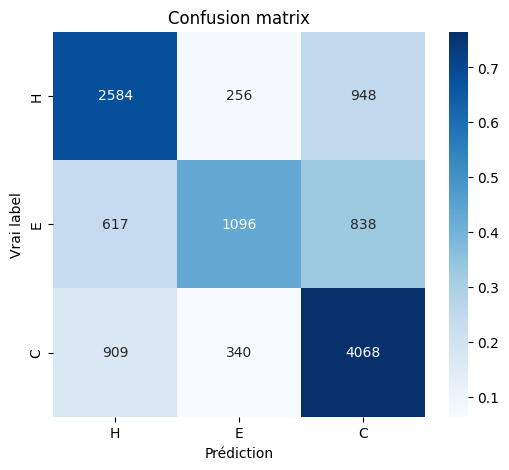

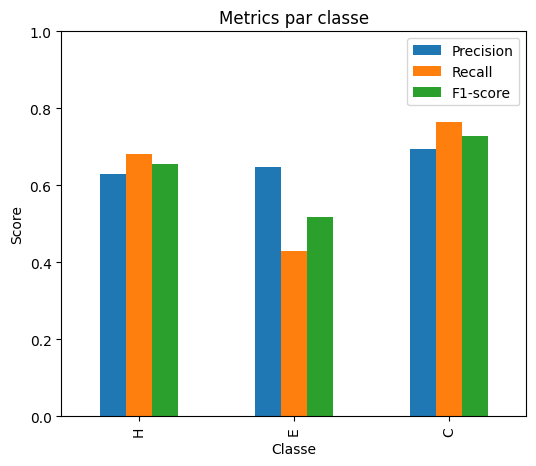

In [9]:
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("Macro F1:", f1_score(y_test, y_test_pred, average='macro'))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred, labels=['H', 'E', 'C']))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_test_pred, labels=['H', 'E', 'C']))

classes = ['H', 'E', 'C']
cm = confusion_matrix(y_test, y_test_pred, labels=classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=cm, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.title('Confusion matrix')
plt.show()

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, labels=classes)
df_metrics = pd.DataFrame({
    'Classe': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1
})

df_metrics.plot(x='Classe', kind='bar', figsize=(6,5))
plt.ylim(0,1)
plt.title('Metrics par classe')
plt.ylabel('Score')
plt.show()

In [10]:
y_test_pred

array(['C', 'C', 'C', ..., 'C', 'C', 'C'], shape=(11656,), dtype='<U1')

In [27]:
inter_1 = 2035
inter_2 = 2050
print("séquence cible",y_test[inter_1:inter_2])
print("séquence prédite",y_test_pred[inter_1:inter_2])


séquence cible ['C' 'H' 'H' 'H' 'H' 'H' 'H' 'C' 'C' 'C' 'C' 'E' 'E' 'E' 'E']
séquence prédite ['C' 'H' 'H' 'H' 'C' 'C' 'E' 'C' 'C' 'E' 'E' 'E' 'E' 'E' 'E']
